In [1]:
from clustering import Clusterer
from data_loader import DataLoader
import numpy as np

/Users/lazarericour-dumas/Library/Python/3.9/lib/python/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 2.0.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/Cellar/python@3.9/3.9.19/Frameworks/Pyth

ImportError: numpy.core.multiarray failed to import

# Loading Files

In [2]:
dirs_test = ["data/ordered_wav/vrai_nom", "data/ordered_wav/faux_nom"]
dirs_ue = ["data/ordered_wav_phrases/ue/real", "data/ordered_wav_phrases/ue/false"]
dirs_ui = ["data/ordered_wav_phrases/ui/real", "data/ordered_wav_phrases/ui/false"]
dirs_ae = ["data/ordered_wav_phrases/ae/real", "data/ordered_wav_phrases/ae/false"]
dirs_ai = ["data/ordered_wav_phrases/ai/real", "data/ordered_wav_phrases/ai/false"]

dl = DataLoader(dirs_test, target_sec=None)
gt = dl.get_ground_truth()


In [33]:
idx, value = min(enumerate(mfcc), key=lambda x: x[1].shape[1])
print (idx)
print (mfcc[idx].shape)

27
(128, 45)


# Display length distribution

Min duration: 1.79s
Max duration: 3.09s
Mean duration: 2.26s
Median duration: 2.26s


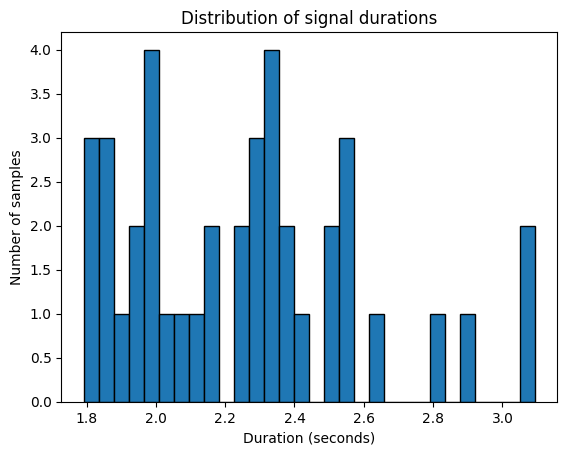

In [15]:
import librosa
import matplotlib.pyplot as plt

durations = []

for i in range (len(dl.mapping)):
    y, sr = librosa.load(dl.mapping[i], sr=None)  # sr=None to keep native sampling rate
    duration = librosa.get_duration(y=y, sr=sr)
    durations.append(duration)

durations = np.array(durations)

# Summary statistics
print(f"Min duration: {durations.min():.2f}s")
print(f"Max duration: {durations.max():.2f}s")
print(f"Mean duration: {durations.mean():.2f}s")
print(f"Median duration: {np.median(durations):.2f}s")

# Plot distribution
plt.hist(durations, bins=30, edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of samples")
plt.title("Distribution of signal durations")
plt.show()

# File Management

In [1]:
import os
import subprocess

def copy_mp4(source_path, destination_dir, sample_rate=22050, mono=True):
    if not os.path.exists(source_path):
        raise FileNotFoundError(f"Source file not found: {source_path}")

    cmd = [
        "ffmpeg",
        "-y",              # overwrite if file exists
        "-i", source_path,        # input file
        "-vn",             # no video
    ]

    if mono:
        cmd += ["-ac", "1"] 
    if sample_rate:
        cmd += ["-ar", str(sample_rate)] 
    
    cmd += [destination_dir]

    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [ ]:
'''
Test phrase
'''
dl = DataLoader(["data/mp4"], target_sec=None)

i = 0
for source in dl.mapping.values():
    if "Vrai " in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/vrai_nom/{i}.wav')
    elif "Faux " in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/faux_nom/{i}.wav')
    elif "[Ae] -" in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/ae/{i}.wav')
    elif "[Ai] -" in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/ai/{i}.wav')
    elif "[Ue] -" in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/ue/{i}.wav')
    elif "[Ui] -" in source:
        copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_mp4/ui/{i}.wav')
    
    else :
        raise ValueError(f'Could not find suitable dir for {source}')
    i+=1

In [8]:
'''
Other phrases
'''
dl = DataLoader(["data/mp4"], target_sec=None)

i = 0
for source in dl.mapping.values():
    if "nom" in source:
        pass
        
    elif "Phrase [Ae]" in source:
        if "[Ae] -" in source:
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ae/real/{i}.wav')
        else :
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ae/false/{i}.wav')
    elif "Phrase [Ai]" in source:
        if "[Ai] -" in source:
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ai/real/{i}.wav')
        else :
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ai/false/{i}.wav')
    elif "Phrase [Ue]" in source:
        if "[Ue] -" in source:
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ue/real/{i}.wav')
        else :
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ue/false/{i}.wav')
    elif "Phrase [Ui]" in source:
        if "[Ui] -" in source:
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ui/real/{i}.wav')
        else :
            copy_mp4(source, f'/Users/mac/Documents/soundClustering/data/ordered_wav_phrases/ui/false/{i}.wav')
    
    else :
        raise ValueError(f'Could not find suitable dir for {source}')
    i+=1

# Clustering

## MFCC

#### KMeans

In [3]:
mfcc = dl.get_MFCC()
cl = Clusterer(_list = mfcc, n_clusters=2)
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 1 0 1 1]
(80, 40)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### DBscan

In [11]:
mfcc = dl.get_MFCC()
cl = Clusterer(_list = mfcc, method="dbscan")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
(80, 40)


#### Spectral

In [13]:
mfcc = dl.get_MFCC()
cl = Clusterer(_list = mfcc, n_clusters=2, method="spectral")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
(80, 40)


#### NMI & AMI

In [14]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score

print (f"AMI : {adjusted_mutual_info_score(clusters, gt)}")
print (f"NMI : {normalized_mutual_info_score(clusters, gt)}")

AMI : 3.3720355273603388e-15
NMI : 0.022998682421012686


#### VIZ

(80, 1, 40)
(80, 40)
(80, 2)


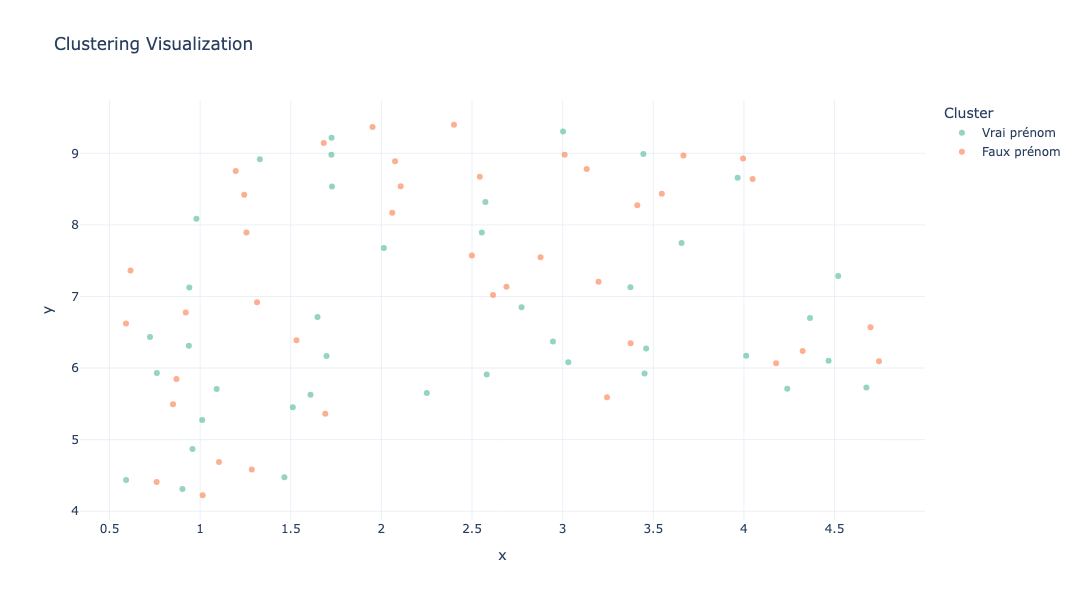

In [4]:
from clustering import ClusterVisualizer
labels = gt
cl_viz = ClusterVisualizer()
mfcc_arr = np.array(mfcc)
print (mfcc_arr.shape)
mfcc_arr = mfcc_arr.reshape(mfcc_arr.shape[0], mfcc_arr.shape[1] * mfcc_arr.shape[2])
print (mfcc_arr.shape)
cl_viz.plot(mfcc_arr, labels)

## MelSpec

#### Kmean

In [ ]:
mel_spec = dl.get_MelSpec()
cl = Clusterer(_list = mel_spec, n_clusters=2)
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

#### DBScan

In [ ]:
mel_spec = dl.get_MelSpec()
cl = Clusterer(_list = mel_spec, method="dbscan")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

#### Spectral

In [ ]:
mel_spec = dl.get_MelSpec()
cl = Clusterer(_list = mel_spec, method="spectral")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

#### AMI & NMI

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score

print (f"AMI : {adjusted_mutual_info_score(clusters, gt)}")
print (f"NMI : {normalized_mutual_info_score(clusters, gt)}")

#### VIZ

In [ ]:
from clustering import ClusterVisualizer
labels = np.array(gt)
cl_viz = ClusterVisualizer()
mel_spec_arr = np.array(mel_spec)
print (mel_spec_arr.shape)
mfcc = mel_spec_arr.reshape(mel_spec_arr.shape[0], mel_spec_arr.shape[1] * mel_spec_arr.shape[2])
print (mel_spec_arr.shape)
cl_viz.plot(mel_spec_arr, labels)

## Signal

#### KMeans

In [5]:
signal = dl.get_signal()
cl = Clusterer(_list = signal, n_clusters=2)
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

AxisError: axis 1 is out of bounds for array of dimension 1

#### DBScan

In [ ]:
signal = dl.get_signal()
cl = Clusterer(_list = signal, method="dbscan")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

#### Spectral

In [ ]:
signal = dl.get_signal()
cl = Clusterer(_list = signal, method="spectral")
cl.extract_features()
clusters = cl.fit_predict()
print (clusters)
print (cl.X.shape)

#### AMI & NMI

In [ ]:
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score

print (f"AMI : {adjusted_mutual_info_score(clusters, gt)}")
print (f"NMI : {normalized_mutual_info_score(clusters, gt)}")

#### VIZ

In [17]:
from clustering import ClusterVisualizer
labels = np.array(gt)
cl_viz = ClusterVisualizer()
signal_arr = np.array(signal)
print (signal_arr.shape)
mfcc = signal_arr.reshape(signal_arr.shape[0], signal_arr.shape[1] * signal_arr.shape[2])
print (signal_arr.shape)
cl_viz.plot(signal_arr, labels)

NameError: name 'signal' is not defined